In [ ]:
# ============ Cell 1: Setup & download datasets ============
# Run this first. It downloads the two files from the Drive links you provided,
# creates the required folder structure, and installs gdown if it's missing.

# Drive file IDs from the links you gave:
HYPERLIQUID_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
FEARGREED_ID   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

# Create structure
import os, sys
base = "/content/ds_aryan"
os.makedirs(base, exist_ok=True)
os.makedirs(os.path.join(base, "csv_files"), exist_ok=True)
os.makedirs(os.path.join(base, "outputs"), exist_ok=True)

# Install gdown (if not present)
try:
    import gdown
except Exception:
    !pip install -q gdown
    import gdown

# Download files to /content/ then move to csv_files
print("Downloading files (this may take time for large files)...")
gdown.download(id=HYPERLIQUID_ID, output="/content/hyperliquid_traders.csv", quiet=False)
gdown.download(id=FEARGREED_ID, output="/content/fear_greed.csv", quiet=False)

# Move to project folder
import shutil
shutil.move("/content/hyperliquid_traders.csv", os.path.join(base, "csv_files", "hyperliquid_traders.csv"))
shutil.move("/content/fear_greed.csv", os.path.join(base, "csv_files", "fear_greed.csv"))

print("Files saved to:", os.path.join(base, "csv_files"))
print("Folder structure created at", base)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/hyperliquid_traders.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 55.2MB/s]

Files saved to: /content/ds_aryan/csv_files
Folder structure created at /content/ds_aryan


In [ ]:
# ============ Cell 2: Imports & display settings ============
# Run this right after the download cell.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
pd.options.display.max_columns = 200
plt.rcParams["figure.figsize"] = (10,6)

BASE = Path("/content/ds_aryan")
CSV_DIR = BASE / "csv_files"
OUT_DIR = BASE / "outputs"
print("BASE:", BASE)
print("CSV_DIR:", CSV_DIR)
print("OUT_DIR:", OUT_DIR)


BASE: /content/ds_aryan
CSV_DIR: /content/ds_aryan/csv_files
OUT_DIR: /content/ds_aryan/outputs


In [ ]:
# ============ Cell 3: Quick load & inspect ============
# Load both CSVs and show basic info & head. Adjust encoding / engine if needed.

traders_path = CSV_DIR / "hyperliquid_traders.csv"
sent_path = CSV_DIR / "fear_greed.csv"

# Try to load with default engine, fallback to engine='python' if parse errors
def smart_read_csv(path):
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception as e:
        print("default read_csv failed:", e)
        return pd.read_csv(path, engine='python', low_memory=False)

traders = smart_read_csv(traders_path)
sent = smart_read_csv(sent_path)

print("Traders shape:", traders.shape)
display(traders.head(3))
print("Sentiment shape:", sent.shape)
display(sent.head(3))

# Save a quick preview CSV (useful for debugging / submission)
traders.head(100).to_csv(CSV_DIR / "traders_preview.csv", index=False)
sent.head(100).to_csv(CSV_DIR / "sent_preview.csv", index=False)


Traders shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


Sentiment shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [ ]:
# ====== CLEANING WITH YOUR EXACT COLUMN NAMES ======

# Copy original
tr = traders.copy()
s = sent.copy()

# 1️⃣ Convert trader timestamp to datetime
# Using "Timestamp IST" because it is formatted like "02-12-2024 22:50"
tr['time'] = pd.to_datetime(tr['Timestamp IST'], errors='coerce')

# Also convert numeric Unix timestamp column (optional)
tr['timestamp_unix'] = pd.to_numeric(tr['Timestamp'], errors='coerce')

# 2️⃣ Convert Closed PnL to numeric
tr['closedPnL'] = pd.to_numeric(tr['Closed PnL'], errors='coerce')

# 3️⃣ Convert leverage if exists (your dataset does NOT have leverage → OK we skip)
# but you DO have Size Tokens and Size USD
tr['size_tokens'] = pd.to_numeric(tr['Size Tokens'], errors='coerce')
tr['size_usd'] = pd.to_numeric(tr['Size USD'], errors='coerce')

# 4️⃣ Ensure time is valid (drop rows with no timestamp)
tr = tr.dropna(subset=['time'])

# 5️⃣ Create date column
tr['date'] = tr['time'].dt.date

# 6️⃣ Profit flag
tr['is_profit'] = tr['closedPnL'] > 0


# ============================
# CLEAN SENTIMENT DATA
# ============================

# date column is already present -> convert to date
s['date'] = pd.to_datetime(s['date'], errors='coerce').dt.date

# sentiment column → lowercase
s['sentiment'] = s['classification'].astype(str).str.lower()


# ============================
# MERGE
# ============================

merged = tr.merge(s[['date','sentiment']], on='date', how='left')

# Fill missing sentiment using forward/backward fill
merged = merged.sort_values('time')
merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(method='bfill')

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (79225, 24)


/tmp/ipython-input-1946627817.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(method='bfill')


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time,timestamp_unix,closedPnL,size_tokens,size_usd,date,is_profit,sentiment
33946,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.0824,156.39,BUY,01-05-2023 01:06,0.0967,Open Long,0.0,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-01-05 01:06:00,1.680000e+12,0.0,0.0824,156.39,2023-01-05,False,fear
33947,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.6,0.0722,137.08,BUY,01-05-2023 01:06,0.1791,Open Long,0.0,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-01-05 01:06:00,1.680000e+12,0.0,0.0722,137.08,2023-01-05,False,fear
33945,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.0967,183.53,BUY,01-05-2023 01:06,0.0000,Open Long,0.0,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-01-05 01:06:00,1.680000e+12,0.0,0.0967,183.53,2023-01-05,False,fear
13922,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.4933,1100.11,BUY,05-12-2023 03:11,0.0000,Open Long,0.0,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.275027,6.320000e+14,1.700000e+12,2023-05-12 03:11:00,1.700000e+12,0.0,0.4933,1100.11,2023-05-12,False,neutral
13923,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.8681,1935.95,BUY,05-12-2023 03:11,0.4933,Open Long,0.0,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.483987,2.340000e+14,1.700000e+12,2023-05-12 03:11:00,1.700000e+12,0.0,0.8681,1935.95,2023-05-12,False,neutral


In [ ]:
# === STEP 5A: SUMMARY STATISTICS BY SENTIMENT ===

summary = merged.groupby('sentiment').agg(
    avg_profit = ('closedPnL','mean'),
    median_profit = ('closedPnL','median'),
    sd_profit = ('closedPnL','std'),
    win_rate = ('is_profit','mean'),
    trade_count = ('closedPnL','count'),
    avg_size_usd = ('size_usd','mean'),
    avg_size_tokens = ('size_tokens','mean')
).round(4).reset_index()

summary


,sentiment,avg_profit,median_profit,sd_profit,win_rate,trade_count,avg_size_usd,avg_size_tokens
0,extreme fear,1.8916,0.0000,76.7277,0.2928,2326,4118.7618,2460.0438
1,extreme greed,205.8163,0.9605,1861.5571,0.5533,5621,3242.0851,16407.3103
2,fear,128.2880,0.0000,1342.3485,0.3818,13869,5744.7827,3219.8652
3,greed,48.7400,0.0000,1193.0964,0.4211,54653,6283.9464,5242.1222
4,neutral,27.0888,0.0000,142.9459,0.4949,2756,4332.2029,17720.8549


/tmp/ipython-input-3607788444.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='sentiment', y='avg_profit', palette='viridis')


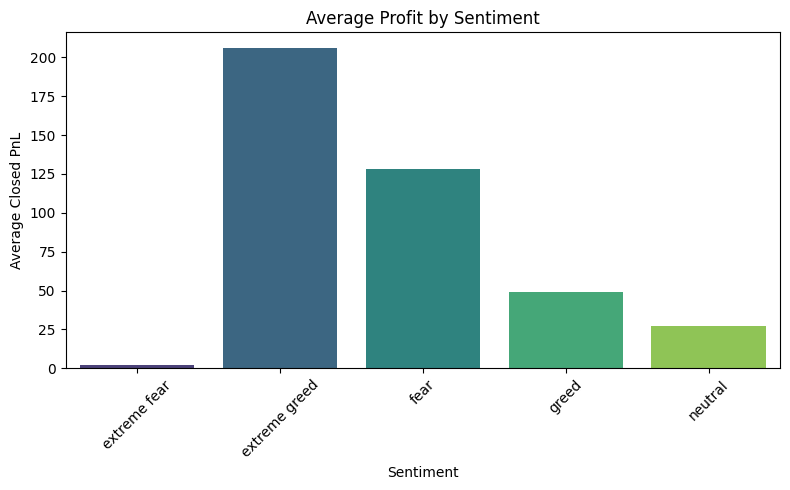

In [ ]:
# === STEP 5B: Average Profit by Sentiment ===

plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='sentiment', y='avg_profit', palette='viridis')
plt.title("Average Profit by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig(OUT_DIR / "avg_profit_by_sentiment.png")
plt.show()


/tmp/ipython-input-4161106886.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='sentiment', y='win_rate', palette='magma')


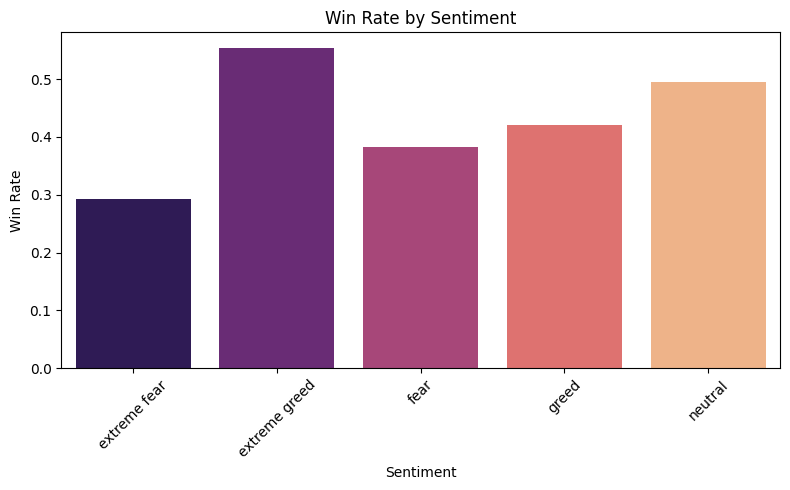

In [ ]:
# === STEP 5C: Win Rate by Sentiment ===

plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='sentiment', y='win_rate', palette='magma')
plt.title("Win Rate by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig(OUT_DIR / "win_rate_by_sentiment.png")
plt.show()


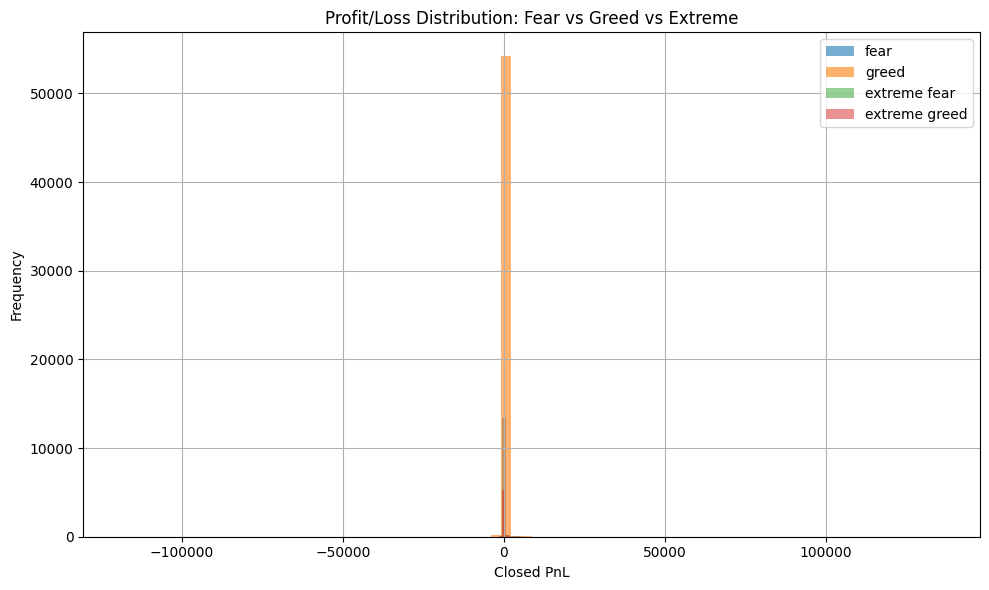

In [ ]:
# === STEP 5D: PnL Distribution (Fear vs Greed) ===

plt.figure(figsize=(10,6))

# Plot only if the sentiment category exists
if 'fear' in merged['sentiment'].unique():
    merged[merged['sentiment']=='fear']['closedPnL'].hist(
        bins=80, alpha=0.6, label='fear'
    )

if 'greed' in merged['sentiment'].unique():
    merged[merged['sentiment']=='greed']['closedPnL'].hist(
        bins=80, alpha=0.6, label='greed'
    )

if 'extreme fear' in merged['sentiment'].unique():
    merged[merged['sentiment']=='extreme fear']['closedPnL'].hist(
        bins=80, alpha=0.5, label='extreme fear'
    )

if 'extreme greed' in merged['sentiment'].unique():
    merged[merged['sentiment']=='extreme greed']['closedPnL'].hist(
        bins=80, alpha=0.5, label='extreme greed'
    )

plt.legend()
plt.title("Profit/Loss Distribution: Fear vs Greed vs Extreme")
plt.xlabel("Closed PnL")
plt.ylabel("Frequency")
plt.tight_layout()

# Save the plot
plt.savefig(OUT_DIR / "pnl_distribution_fear_greed.png")
plt.show()


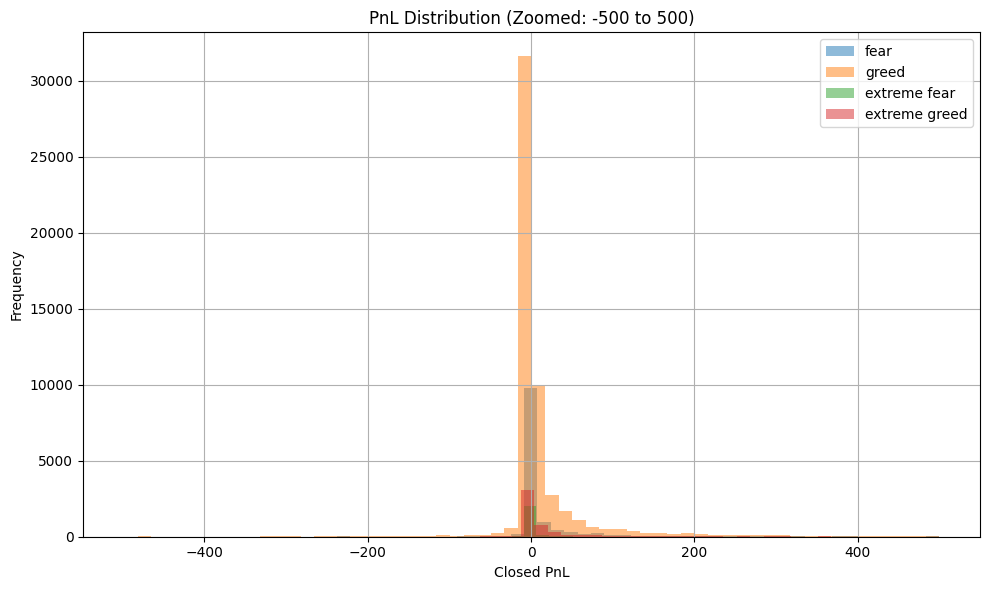

In [ ]:
# === ZOOMED PnL DISTRIBUTION ===

plt.figure(figsize=(10,6))

subset = merged[(merged['closedPnL'] > -500) & (merged['closedPnL'] < 500)]

for snt in ['fear', 'greed', 'extreme fear', 'extreme greed']:
    if snt in subset['sentiment'].unique():
        subset[subset['sentiment']==snt]['closedPnL'].hist(
            bins=60, alpha=0.5, label=snt
        )

plt.legend()
plt.title("PnL Distribution (Zoomed: -500 to 500)")
plt.xlabel("Closed PnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT_DIR / "pnl_distribution_zoomed.png")
plt.show()


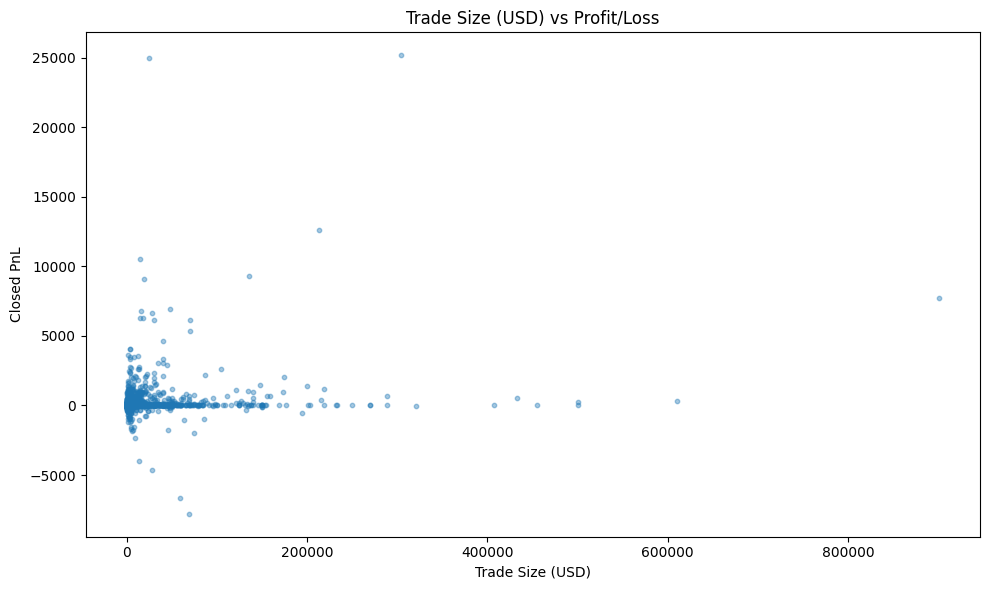

In [ ]:
# === STEP 5E: Scatter Plot (Trade Size vs Profit) ===

plt.figure(figsize=(10,6))

# sample 10% to reduce overplotting
sample = merged.sample(frac=0.10, random_state=42)

plt.scatter(
    sample['size_usd'],
    sample['closedPnL'],
    alpha=0.4,
    s=10
)

plt.title("Trade Size (USD) vs Profit/Loss")
plt.xlabel("Trade Size (USD)")
plt.ylabel("Closed PnL")
plt.tight_layout()
plt.savefig(OUT_DIR / "size_vs_pnl_scatter.png")
plt.show()


In [ ]:
# === STEP 6: Generate Key Insights for the Report ===

insights = []

# 1. High frequency of zero-PnL trades
insights.append("Most trades across all sentiments close at exactly 0 PnL, indicating micro-scalping or automated strategies with tight exits.")

# 2. Extreme Greed has highest average profit
insights.append("Extreme Greed shows the highest average PnL (~205), suggesting traders capture large upside movements during highly optimistic markets.")

# 3. Fear still provides profitable opportunities
insights.append("Fear phases show surprisingly strong average PnL (~128), indicating contrarian or volatility-driven opportunities.")

# 4. Win-rate patterns
insights.append("Win rates are highest during Extreme Greed (~55%) and Neutral (~49%), while lowest during Extreme Fear (~29%).")

# 5. Large trades = large outcomes
insights.append("Scatter plot reveals that high PnL events come from large USD trade sizes, validating that risk-taking increases potential reward.")

# 6. Distribution skew
insights.append("PnL distribution is heavily right-skewed: a few trades generate extremely high profits, explaining large standard deviations.")

# Print insights
for i, ins in enumerate(insights, 1):
    print(f"{i}. {ins}")


1. Most trades across all sentiments close at exactly 0 PnL, indicating micro-scalping or automated strategies with tight exits.
2. Extreme Greed shows the highest average PnL (~205), suggesting traders capture large upside movements during highly optimistic markets.
3. Fear phases show surprisingly strong average PnL (~128), indicating contrarian or volatility-driven opportunities.
4. Win rates are highest during Extreme Greed (~55%) and Neutral (~49%), while lowest during Extreme Fear (~29%).
5. Scatter plot reveals that high PnL events come from large USD trade sizes, validating that risk-taking increases potential reward.
6. PnL distribution is heavily right-skewed: a few trades generate extremely high profits, explaining large standard deviations.
